In [1]:
# import libraries
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import safe as sf
import datamol as dm
from safe.utils import compute_side_chains
import csv
from rdkit import Chem
from rdkit.Chem import AllChem

# Load pre-trained model
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

## Scaffold Morphing
It requires side chains as input.

Steps:
* Get SMILES
* Extract core from SMILES (convert SMILES to molecule to do this)
* Pass in SMILES and core to generate side chain
* Finally, pass in side chain to the model to generate the molecules for scaffold morphing.

In the rest of this notebook, I'll be playing around with codes to achieve different parts of this.

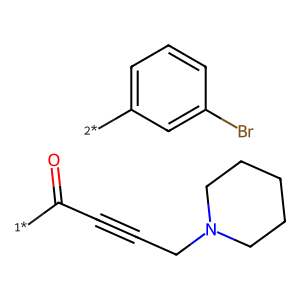

In [8]:
side_chains = "[1*]C(=O)C#CCN1CCCCC1.[2*]c1cccc(Br)c1"
dm.to_image(side_chains)

In [9]:
generated_smiles = designer.scaffold_morphing(
    side_chains=side_chains,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

generated_smiles

  0%|          | 0/1 [00:00<?, ?it/s]/home/affiah/anaconda3/envs/safe/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:430: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
2024-01-17 18:25:25.241 | INFO     | safe.sample:_fragment_linking:397 - After sanitization, 12 / 12 (100.00 %)  generated molecules are valid !


['O=C(C#CCN1CCCCC1)CCC(=O)N1CC[C@H](c2cccc(Br)c2)C1',
 'O=C(C#CCN1CCCCC1)[C@H]1CCN(C(=O)CCc2cccc(Br)c2)C1',
 'O=C(C#CCN1CCCCC1)NC(=S)Nc1cccc(Br)c1',
 'O=C(C#CCN1CCCCC1)NC(=S)Nc1cccc(Br)c1',
 'O=C(C#CCN1CCCCC1)N1CCC(c2cccc(Br)c2)CC1',
 'O=C(C#CCN1CCCCC1)C1CCN(c2cccc(Br)c2)CC1',
 'O=C(NCCCOC(=O)C#CCN1CCCCC1)Nc1cccc(Br)c1',
 'O=C(C#CCN1CCCCC1)NC(=O)NCCCOc1cccc(Br)c1',
 'O=C(C#CCN1CCCCC1)CC(=O)NCCOc1cccc(Br)c1',
 'O=C(Cc1cccc(Br)c1)NCCOC(=O)C#CCN1CCCCC1',
 'O=C(C#CCN1CCCCC1)CCC(=O)NCC(=O)OCc1cccc(Br)c1',
 'O=C(C#CCN1CCCCC1)COC(=O)CNC(=O)CCc1cccc(Br)c1']

12


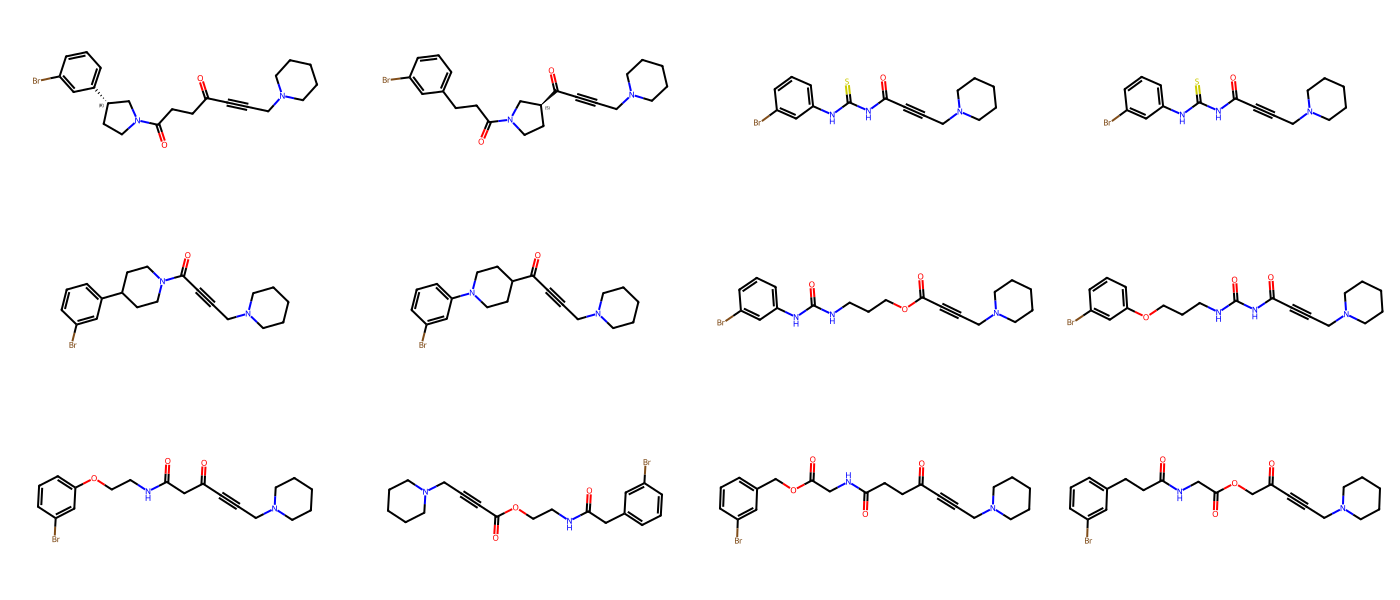

In [10]:
print(len(generated_smiles))
dm.to_image(generated_smiles[:12], mol_size=(350, 200))

## Testing core structure

In [3]:
# Define the core structure of triazolopyrazine
core_structure = "N1=CC=N[N]1"

# Generate scaffold morphing
generated_smiles = designer.scaffold_morphing(
    core=core_structure,
    n_samples_per_trial=12,
    n_trials=1,
    sanitize=True,
    do_not_fragment_further=False,
    random_seed=100,
)

# Display the generated SMILES
print(generated_smiles)

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.ReplaceCore(NoneType, Mol)
did not match C++ signature:
    ReplaceCore(RDKit::ROMol mol, RDKit::ROMol coreQuery, bool replaceDummies=True, bool labelByIndex=False, bool requireDummyMatch=False, bool useChirality=False)
    ReplaceCore(RDKit::ROMol mol, RDKit::ROMol core, boost::python::api::object matches, bool replaceDummies=True, bool labelByIndex=False, bool requireDummyMatch=False)

### Convert Molecule to Side Chain

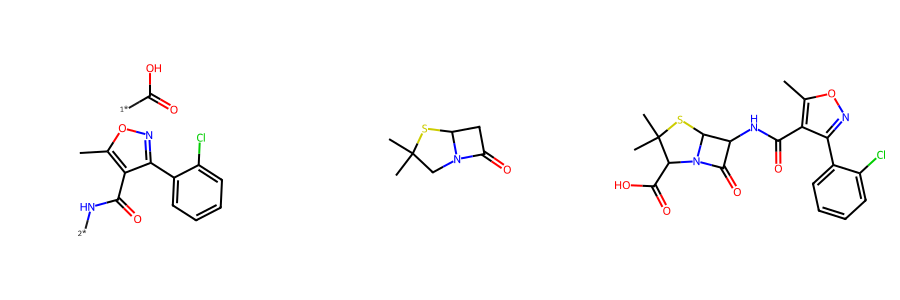

In [11]:
mol = "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O"
core0 = "CC1(C)CN2C(CC2=O)S1"
core1 = "CC1(C)SC2C(-*)C(=O)N2C1-*"
core2 = "CC1N2C(SC1(C)C)C(N)C2=O"
side_chain = compute_side_chains(core=core0, mol=mol)
print(side_chain)
dm.to_image([side_chain, core0, mol])

### Testing the main.py script

In [3]:
# convert SMILES to SAFE
def smiles_to_safe(smiles):
    try:
        safe = sf.encode(smiles)
        return safe
    # except sf.EncoderError:
    except:
        print("Error in SMILES conversion")


def extract_core_structure(molecule):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(molecule)

    # Generate 2D coordinates
    mol = AllChem.Compute2DCoords(mol)

    # Identify the core structure using the Murcko Scaffold
    core = Chem.MurckoScaffold.GetScaffoldForMol(mol)

    # Convert the core structure back to SMILES
    core_smiles = Chem.MolToSmiles(core)

    return core_smiles


#  convert core structure to side chain
def side_chains(core_structure):
    return core_structure


# generate new smiles
def generate_smiles(side_chains):
    generated_smiles = designer.scaffold_morphing(
        side_chains=side_chains,
        n_samples_per_trial=12,
        n_trials=1,
        sanitize=True,
        do_not_fragment_further=False,
        random_seed=100,)
    return generated_smiles

# my model
def my_model(side_chains_list):
    return [generate_smiles(side_chains) for side_chains in side_chains_list]


# read SMILES from .csv file, assuming one column with header
with open("data/my_molecules.csv", "r") as f:
    reader = csv.reader(f)
    next(reader)  # skip header
    smiles_list = [r[0] for r in reader]

# Load pre-trained model
designer = sf.SAFEDesign.load_default(verbose=True)
designer.model

# convert to SAFE
safe_list = [smiles_to_safe(smi) for smi in smiles_list]

# convert molecule to side chains
side_chains_list = [side_chains(sf) for sf in safe_list]

# run model
outputs = my_model(smiles_list)
outputs

2024-01-17 14:42:37.121 | WARNING  | safe.sample:_fragment_linking:239 - Side chain NCCS does not contain any dummy atoms, this might not be what you want


Error in SMILES conversion


IndexError: list index out of range

### Test Core Extraction Function

In [5]:
def extract_core_structure(molecule):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(molecule)

    # Identify the core structure using the Murcko Scaffold
    core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)

    # Convert the core structure back to SMILES
    core_smiles = Chem.MolToSmiles(core)

    return core_smiles

mol = "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O"
core_structure = extract_core_structure(mol)
print("Core Structure:", core_structure)

Core Structure: O=C(NC1C(=O)N2CCSC12)c1conc1-c1ccccc1


MurckoScaffold + GetMolFrags

In [13]:
def extract_core_structure(molecule):
    # Convert SMILES to RDKit molecule
    mol = Chem.MolFromSmiles(molecule)

    # Identify the core structure using the Murcko Scaffold
    core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)

    # Get the fragments of the core structure
    fragments = Chem.GetMolFrags(core, asMols=True)

    # # Select the largest fragment based on the number of atoms
    largest_fragment = max(fragments, key=lambda x: x.GetNumAtoms())
    

    # Convert the largest fragment back to SMILES
    core_smiles = Chem.MolToSmiles(largest_fragment)

    return core_smiles

# Example usage:
mol = "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O"
core_structure = extract_core_structure(mol)
print("Core Structure:", core_structure)

Core Structure: O=C(NC1C(=O)N2CCSC12)c1conc1-c1ccccc1


#### More Experimentation

In [2]:
molecule = "CC1=C(C(=NO1)C2=CC=CC=C2Cl)C(=O)NC3C4N(C3=O)C(C(S4)(C)C)C(=O)O"
# molecule = "N#Cc1ccc(-c2nnc3cncc(OCCc4ccc(F)c(F)c4)n23)cc1"
# molecule = "FC1=CC=C(CCOC2=CN=CC3=NN=C(N23)C2=CC=C(C(OC3CC3)=C2)C2=CC(OC3CC3)=C(Cl)C=C2)C=C1F"
mol = Chem.MolFromSmiles(molecule)
fragments = Chem.GetMolFrags(mol, asMols=True)

for i in fragments:
    print("Fragment", i)
    core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(i)
    print(Chem.MolToSmiles(core))

ArgumentError: Python argument types in
    rdkit.Chem.rdmolops.MurckoDecompose(tuple)
did not match C++ signature:
    MurckoDecompose(RDKit::ROMol mol)

In [49]:
molecule = "FC1=CC=C(CCOC2=CN=CC3=NN=C(N23)C2=CC=C(C(OC3CC3)=C2)C2=CC(OC3CC3)=C(Cl)C=C2)C=C1F"
mol = Chem.MolFromSmiles(molecule)
core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)
core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(core)
core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(core)
print(Chem.MolToSmiles(core))
# fragments = Chem.GetMolFrags(core, asMols=True)

# for i in fragments:
#     core_smiles = Chem.MolToSmiles(i)
#     print(core_smiles)


c1ccc(CCOc2cncc3nnc(-c4ccc(-c5cccc(OC6CC6)c5)c(OC5CC5)c4)n23)cc1


In [28]:
mol = Chem.MolFromSmiles(molecule)
core = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)
fragments = Chem.GetMolFrags(core, asMols=False)
print(fragments)

# Select the largest fragment based on the number of atoms
largest_fragment = max(fragments, key=lambda x: x.GetNumAtoms())

# Convert the largest fragment back to SMILES
core_smiles = Chem.MolToSmiles(largest_fragment)
print(core_smiles)


()


ValueError: max() arg is an empty sequence